### Introduction to Nilearn and image manipulation

The goal of this notebook is to help get you comfortable with manipulating functional and anatomical images using nilearn. We'll be using the techniques we learned here in our final analysis...

#### Content:
1. Basic Image Operations and Masking
2. Resampling data to work across modalities (T1/FUNC)

In [3]:
import os
import matplotlib.pyplot as plt #to enable plotting within notebook
from nilearn import image as img
from nilearn import plotting as plot
import bids.layout
import matplotlib.animation
from IPython.display import HTML

In [4]:
#magic function to view matplotlib images in notebook
%matplotlib inline 

Let's grab some sample images from fmriprep using BIDSLayout from pybids.

In [5]:
#Base directory for fmriprep output
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout=bids.BIDSLayout(fmriprep_dir, validate=False)
T1w_files = layout.get(subject='10171', datatype='anat', suffix='preproc')
brainmask_files = layout.get(subject='10171', datatype='anat', suffix='brainmask')
func_files = layout.get(subject='10171', datatype='func', suffix='preproc')
func_mask_files = layout.get(subject='10171', datatype='func', suffix='brainmask')

In [6]:
#Display preprocessed files inside of anatomy folder
for f in T1w_files:
    print(f.path)

/Users/oliviastanley/Documents/Code/scwg2018_python_neuroimaging/data/ds000030/derivatives/fmriprep/sub-10171/anat/sub-10171_T1w_preproc.nii.gz
/Users/oliviastanley/Documents/Code/scwg2018_python_neuroimaging/data/ds000030/derivatives/fmriprep/sub-10171/anat/sub-10171_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz


### Warming up with Nilearn 

#### Basic Image operations
Here we show how easy it is to apply a mask to nifti images using nilearn. 
We first pick an example T1 image and mask from the fmriprep output, then we apply the mask and view the result...

In [7]:
#How does nilearn deal with images
ex_T1 = T1w_files[0].path
ex_bm = brainmask_files[0].path
print(ex_T1, ex_bm)

/Users/oliviastanley/Documents/Code/scwg2018_python_neuroimaging/data/ds000030/derivatives/fmriprep/sub-10171/anat/sub-10171_T1w_preproc.nii.gz /Users/oliviastanley/Documents/Code/scwg2018_python_neuroimaging/data/ds000030/derivatives/fmriprep/sub-10171/anat/sub-10171_T1w_brainmask.nii.gz


/Users/oliviastanley/miniconda3/envs/conpcourse/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


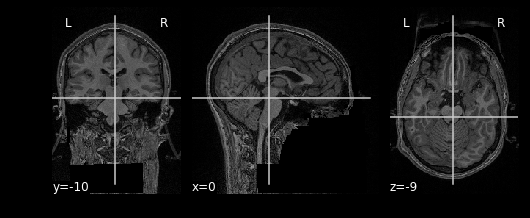

In [8]:
#Viewing T1
plot.plot_anat(ex_T1)

An equivalent tool in the nibabel package is the OrthoSlicer3D tool. An example for this is provided below.

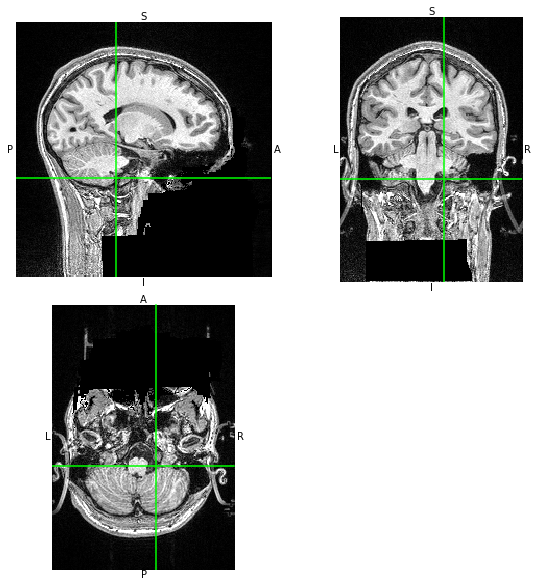

In [9]:
import nibabel as nb
veiw=nb.viewers.OrthoSlicer3D(nb.load(ex_T1).get_data())
veiw.set_position(100,100,100)

Nilearn uses nibabel under the hood to store nifti images. So you can think of images (similar to nibabel) as a 3D array (volume) with values assigned to each (x,y,z) coordinate. With 3D arrays we can perform operations and nilearn makes simple

Say we wanted to invert a T1 image, that is flip the colorscale. We could do this as follows:

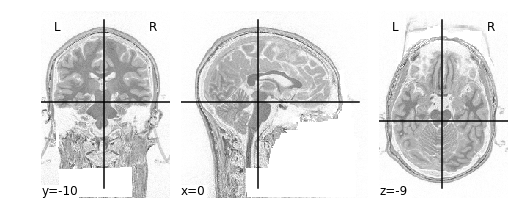

In [10]:
#Inverting a T1 image example
invert_img = img.math_img('-a',a=ex_T1)
plot.plot_anat(invert_img) 

Now we could use a similar technique to apply a mask. 
A mask is simply a 3D volume with 0's and 1's. The 1's indicate the areas in which areas are to be preserved. 

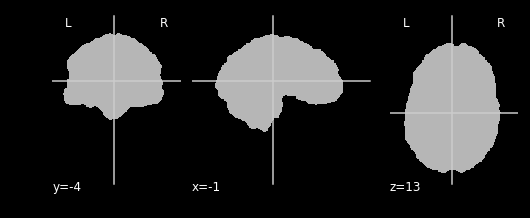

In [11]:
#Viewing mask
plot.plot_anat(ex_bm) 

The idea behind applying a mask is multiplying the mask directly by the image in an element-wise fashion. 
The end result is that all voxels (x,y,z) in the T1 image corresponding with a 1 in the mask with the same coordinate (x,y,z) is preserved. Everything else is put to 0.

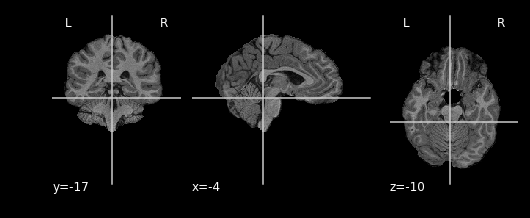

In [12]:
#Applying a mask is as easy as using the straight formula
masked_t1 = img.math_img('a*b',a=ex_T1,b=ex_bm)
plot.plot_anat(masked_t1)

**Exercise** 

Try applying the mask but getting everything but the brain!

**Solution**:

This is a two step process. Since the mask has a value of $1$ on areas *we want to keep* and values of $0$ in areas we don't want to keep. The way we can switch this around is by the following:

1. Switch $1 \to 0$
2. Switch $0 \to 1$

This is done by starting with the value of $1$ and subtracting the mask from it.

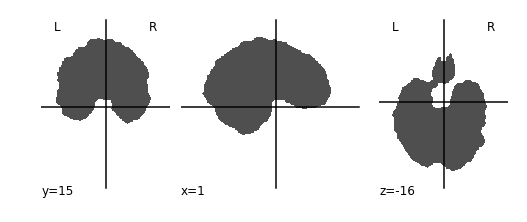

In [13]:
#Invert the mask
inverted_mask = img.math_img('1-a',a=ex_bm)
plot.plot_anat(inverted_mask)

Now we can apply this mask! Notice that now the areas indicating the brain are black (value is $0$), and the background (which includes the skull) is white (value is $1$). 

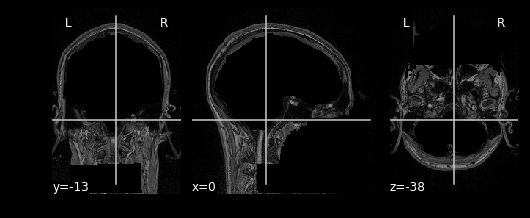

In [14]:
no_brain_t1 = img.math_img('a*b',a=ex_T1,b=inverted_mask)
plot.plot_anat(no_brain_t1) 

#### Resampling
Recall from our nibabel exploration of neuroimaging data:

- T1 images are typically composed of voxels that are 1x1x1 in dimension
- Functional images are typically composed of voxels that are 2x2x2 in dimension

If we'd like to overlay our functional on top of our T1 (for visualization purposes, or analyses), then we need to match the size of the voxels! 

Think of this like trying to overlay a 10x10 JPEG and a 20x20 JPEG on top of each other. To get perfect overlay we need to resize (or more accurately *resample*) our JPEGs to match!

**Note**: 
Resampling is a method of interpolating in between data-points. When we stretch an image we need to figure out what goes in the spaces that are created via stretching - resampling does just that. In fact, resizing any type of image is actually just resampling to new dimensions. 

Let's resampling some MRI data using nilearn. 

**Goal**: Match the dimensions of the structural image to that of the functional image

In [15]:
#Files we'll be using (Notice that we're using _space-MNI..._ which means they are normalized brains)
ex_mni_T1 = T1w_files[1].path
ex_mni_FUNC = brainmask_files[1].path

Note below that when we load an image, it reads in as a nibabel image. 
Meaning we can use the same utilities we used in nibabel on this data!

In [16]:
t1 = img.load_img(ex_mni_T1)
func = img.load_img(ex_mni_FUNC)
print(type(t1))

<class 'nibabel.nifti1.Nifti1Image'>


Now we demonstrate our problem with the dimensions of the image not matching

In [17]:
print(t1.shape)
print(func.shape)

(193, 229, 193)
(193, 229, 193)


Resampling in nilearn is as easy as telling it which image you want to sample and what the target image is.
Structure of function:

img.resample_to_img(source_img,target_img,interpolation) 
- source_img = the image you want to sample
- target_img = the image you wish to *resample to* 
- interpolation = the method of interpolation

A note on **interpolation**

nilearn supports 3 types of interpolation, the one you'll use depends on the type of data you're resampling!
1. **continuous** - Interpolate but maintain some edge features.  Ideal for structural images where edges are well-defined. Uses $3^\text{rd}$-order spline interpolation.
2. **linear (default)** - Interpolate uses a combination of neighbouring voxels - will blur. Uses trilinear interpolation.
3. **nearest** - matches value of closest voxel (majority vote from neighbours). This is ideal for masks which are binary since it will preserve the 0's and 1's and will not produce in-between values (ex: 0.342). Also ideal for numeric labels where values are 0,1,2,3... (parcellations). Uses nearest-neighbours interpolation with majority vote.


(193, 229, 193)
(193, 229, 193)


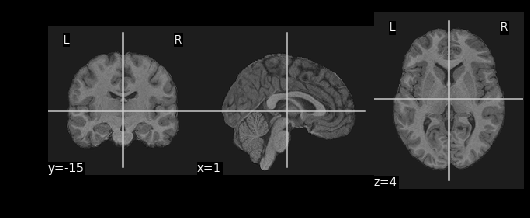

In [18]:
#Try playing around with methods of interpolation
#options: 'linear','continuous','nearest'
resamp_t1 = img.resample_to_img(source_img=t1,target_img=func,interpolation='continuous')
print(resamp_t1.shape)
print(func.shape)
plot.plot_anat(resamp_t1)

An example of this resampling is shown in the gif below. Feel free to click through it or change the images to the functional if you like.

In [19]:
%%capture
%matplotlib inline
#Resample the T1 to the size of the functional image!
ex_func = func_files[0].path
resamp_t1 = img.resample_to_img(source_img=ex_T1, target_img=ex_func, interpolation='continuous')
T1_img=img.load_img(ex_T1)
fig, ax = plt.subplots()

def animate(image):
    plot.plot_anat(image, figure=fig, cut_coords=(0,0,0))
    ax.set_facecolor('black')
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=[resamp_t1, T1_img]) 
#change the frames to look at the functional mask over the resampled T1
# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=[resamp_t1, func]) 

In [20]:
# Display animation
HTML(ani.to_jshtml())

/Users/oliviastanley/miniconda3/envs/conpcourse/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


**Exercise**

Using **Native** T1 and **T1w** resting state functional do the following:
1. Resample the native T1 image to resting state size
2. Replace the brain in the T1 image with the first frame of the resting state brain

In [17]:
#Files we'll need

#This is the pre-processed resting state data that hasn't been standardized
ex_func = func_files[0].path

#This is the associated mask for the resting state image.
ex_func_bm = func_mask_files[0].path

The first step we need to do is to make sure the dimensions for our T1 image and resting state image match each other:

/Users/oliviastanley/miniconda3/envs/conpcourse/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


(65, 77, 49)


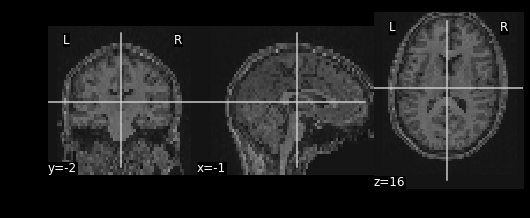

In [34]:
#Resample the T1 to the size of the functional image!
resamp_t1 = img.resample_to_img(source_img=ex_T1, target_img=ex_func, interpolation='continuous')
plot.plot_anat(resamp_t1)
print(resamp_t1.shape)

Next we want to make sure that the brain mask for the T1 is also the same dimensions as the functional image. This is exactly the same as above, except we use the brain mask as the source.

What kind of interpolation should we use for masks? 

/Users/oliviastanley/miniconda3/envs/conpcourse/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


(65, 77, 49)


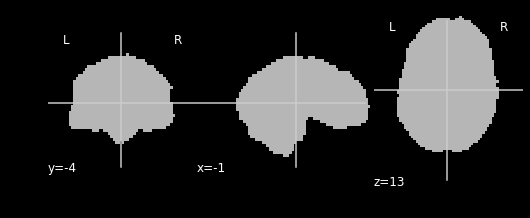

In [33]:
resamp_bm = img.resample_to_img(source_img=ex_bm, target_img=ex_func,interpolation='nearest')
plot.plot_anat(resamp_bm)
print(resamp_bm.shape)

Once we've resampled both our T1 and our brain mask. We now want to remove the brain from the T1 image so that we can replace it with the funtional image instead. Remember to do this we need to:

1. Invert the T1 mask
2. Apply the inverted mask to the brain

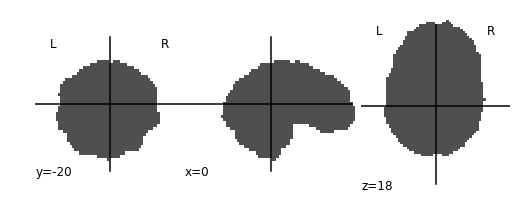

In [20]:
inverted_bm_t1 = img.math_img('1-a',a=resamp_bm)
plot.plot_anat(inverted_bm_t1)

Now apply the mask:

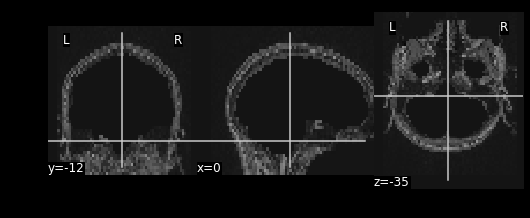

In [21]:
resamp_t1_nobrain = img.math_img('a*b',a=resamp_t1,b=inverted_bm_t1)
plot.plot_anat(resamp_t1_nobrain)

We now have a skull missing the structural T1 brain. The final steps is to stick in the brain from the functional image into the now brainless head. First we need to remove the surrounding signal from the functional image.

Since a functional image is 4-Dimensional, we'll need to pull the first volume to work with. This is because the structural image is 3-dimensional and operations will fail if we try to mix 3D and 4D data.

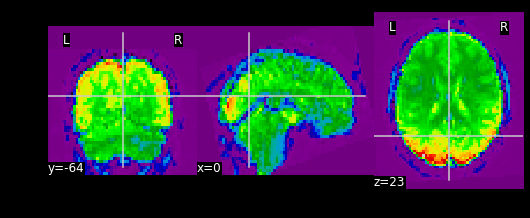

In [22]:
#Let's visualize the first volume of the functional image:
func_img = img.load_img(ex_func)
first_vol = func_img.slicer[:,:,:,0]
plot.plot_epi(first_vol)

As shown in the figure above, the image has some "signal" outside of the brain. In order to place this within the now brainless head we made earlier, we need to mask out the functional MR data as well!

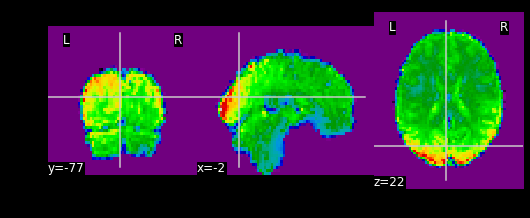

In [23]:
masked_func = img.math_img('a*b', a=first_vol, b=ex_func_bm)
plot.plot_epi(masked_func)

The final step is to stick this data into the head of the T1 data. Since the hole in the T1 data is represented as $0$'s. We can add the two images together to place the functional data into the void:

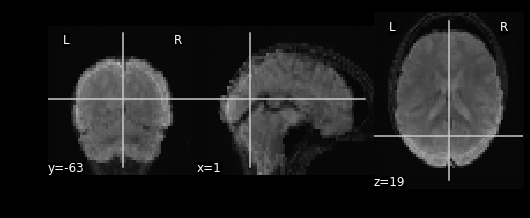

In [24]:
#Now overlay the functional image on top of the anatomical
combined_img = img.math_img('a+b',a=resamp_t1_nobrain,b=masked_func)
plot.plot_anat(combined_img)

### Finished!
Hopefully you've gained some intuition and comfort in dealing with MRI images using nilearn/nibabel. 

Now we'll take what we've used here, add some additional features and perform a full analysis on a dataset